# Evaluation des Modells
Import der verwendeten Pakete

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from joblib import load
from tensorflow.keras.models import load_model
from service.DataService import DataService

## Einstellungen für das Speichern der Bilddateien

In [2]:
save_plot = True
fontsize = 14
y_lim = 2.6, 4.1

## Laden des trainierten Modells, der Trainingsdaten, der Testdaten und dem StandardScaler

In [3]:
ds = DataService()
# Laden des trainierten Modells
model = load_model('../../data/model/LGT92_LSTM_model_thesis.h5')

X_train, y_train = load('../../data/trainingsdata/LGT92-23-33_trainingsdata_for_RNN')
X_train_raw, y_train_raw = load('../../data/trainingsdata/LGT92-23-33_trainingsdata_for_RNN_RAW')
X_23_test, y_23_test = load('../../data/testdata/LGT92-23_restructured_testdata_for_RNN')
X_23_test_raw, y_23_test_raw = load('../../data/testdata/LGT92-23_testdata_for_RNN_RAW')
X_33_test, y_33_test = load('../../data/testdata/LGT92-33_restructured_testdata_for_RNN')
X_33_test_raw, y_33_test_raw = load('../../data/testdata/LGT92-33_testdata_for_RNN_RAW')

df_325723_full_curve = load('../../data/sensor_data/df_325723_full_curve')
df_325733_full_curve = load('../../data/sensor_data/df_325733_full_curve')
df_325723_full_curve_1 = load('../../data/sensor_data/df_325723_full_curve_1')
df_325733_full_curve_1 = load('../../data/sensor_data/df_325733_full_curve_1')

scaler_x = load('../../data/scaler/LGT92_LSTM_scaler_x_thesis.joblib')
scaler_y = load('../../data/scaler/LGT92_LSTM_scaler_y_thesis.joblib')

df_trained_data = pd.read_pickle('../../data/sensor_data/dataframe_trained_data.pkl')

Metal device set to: Apple M1 Pro


2023-06-24 15:42:26.005955: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-24 15:42:26.006494: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Erstellen des Testdatensatzes des Sensor LGT92-325744

In [4]:
# NEW Testset LGT92-325744
df_325744 = ds.pickle_to_pandas_dataframe('fb1c9420-a5f8-11ed-8fa7-8d95df41b8ce_Thesis_extended_RAW',
                                          ['data_BatV', 'data_rssi', 'data_snr'],
                                          missing_values='lag_impute')

df_325744_full_curve = ds.create_full_curve_thesis(df_325744.iloc[:1000], 'data_BatV')
df_325744_full_curve_raw = df_325744.loc[df_325744['data_BatV'].idxmax():].copy()
df_325744_full_curve_1 = ds.create_full_curve_thesis(df_325744_full_curve_raw, 'data_BatV')

df_test = pd.concat([df_325744_full_curve, df_325744_full_curve_1], ignore_index=True)
my_date_range_test = pd.date_range(end=df_325744.index[-1], periods=len(df_test), freq='H')
df_test['date'] = my_date_range_test
df_test.set_index('date', inplace=True)
df_test.fillna(0, inplace=True)
df_test.index.freq = 'H'

# Add ID for evaluation, because the model does not know its own ID
df_test['3f394130-a5f9-11ed-8fa7-8d95df41b8ce'] = 0
df_test['6aa082d0-a5f8-11ed-8fa7-8d95df41b8ce'] = 1

window = 24
indicators = 5
horizon = 1

# Restructure testdata for LSTM
X_test_44_raw = df_test[
    ['rm_data_BatV', '6aa082d0-a5f8-11ed-8fa7-8d95df41b8ce', '3f394130-a5f9-11ed-8fa7-8d95df41b8ce', 'start',
     'end']].values
y_test_44_raw = df_test[['rm_data_BatV']].values

X_test_44_std = scaler_x.transform(X_test_44_raw)
y_test_44_std = scaler_y.transform(y_test_44_raw)

X_44_test, y_44_test = ds.restructure_data_for_lstm(X_test_44_std, y_test_44_std, window=window, horizon=horizon)

# Evaluation des Modells auf dem Testdatensatz des Sensor LGT92-325723
Evaluation und Visualisierung der Prädiktion über den gesamten Testdatensatz

2023-06-24 15:42:26.438255: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-24 15:42:26.615978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-24 15:42:26.673177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 1s

2023-06-24 15:42:26.975183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 46ms/step


2023-06-24 15:42:27.428040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-24 15:42:27.482149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-24 15:42:27.550232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 36ms/step - loss: 8.9892e-05 - mae: 0.0073
Mean Absolute Error for multiple Forecast: 0.01194188328033099
Mean Squad Error for multiple Forecast: 2.838873377082587e-08
MAE der Evaluation über die Testdaten:  0.007318356540054083


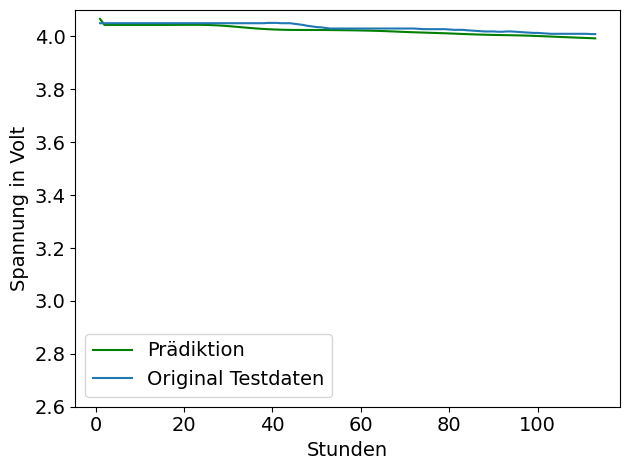

In [5]:
# predict for testdata
y_pred_test = model.predict(X_23_test)
mae_evaluation = model.evaluate(X_23_test, y_23_test)

# descale prediction
y_pred_test_inv = scaler_y.inverse_transform(y_pred_test)

# Mean Absolute Error berechnen
mae = mean_absolute_error(y_23_test_raw[:len(X_23_test)], scaler_y.inverse_transform(y_pred_test))
rmse = np.square(mean_squared_error(y_23_test_raw[:len(X_23_test)], scaler_y.inverse_transform(y_pred_test)))
# print mae & rmse
print("Mean Absolute Error for multiple Forecast:", mae)
print("Mean Squad Error for multiple Forecast:", rmse)
# Ausgabe der Metriken
print('MAE der Evaluation über die Testdaten: ', mae_evaluation[1])

# plot results
plt.plot(np.linspace(1, len(y_pred_test_inv), len(y_pred_test_inv)), y_pred_test_inv, color='green', label='Prädiktion')
plt.plot(np.linspace(1, len(y_23_test_raw[:113]), len(y_23_test_raw[:113])), y_23_test_raw[:113],
         label='Original Testdaten')
plt.ylim(y_lim)
plt.xlabel('Stunden', fontsize=fontsize)
plt.ylabel('Spannung in Volt', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
if save_plot:
    plt.savefig(f'../../data/png/evaluate_X_23_test_predict_testdata', pad_inches=2)
plt.show()


## Evaluation des Modells auf dem Testdatensatz des Sensor LGT92-325723 für jeden Zeitschritt

1/1 [==============================] - 0s 16ms/step


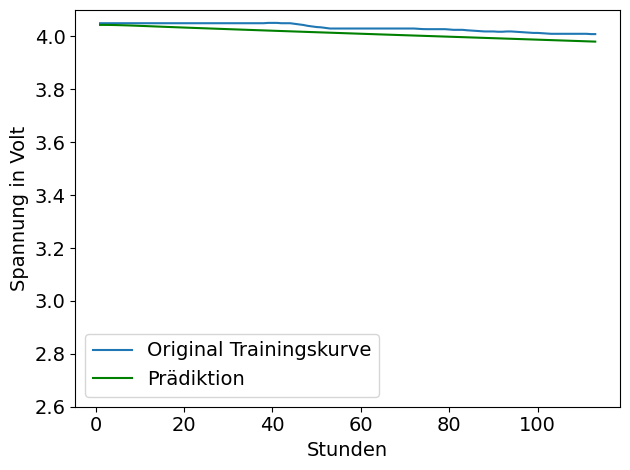

Mean Absolute Error for multiple Forecast: 0.021843901244572958
Root Mean Squad Error for multiple Forecast: 2.672584366572e-07


In [6]:
# multiple prediction over Testdata 325723
multi_pred_testdata = ds.multiple_prediction(window_slot=1, window=window, indicators=indicators,
                                             future_steps=len(X_23_test), model=model, input_data=X_23_test,
                                             scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_23_test_raw, predicted=multi_pred_testdata, period=len(X_23_test), y_lim=y_lim,
                   window_slot=1, fontsize=14, data_name='multi_pred_testdata')

# Metriks
mae_mptd = mean_absolute_error(y_23_test_raw[:len(multi_pred_testdata)], multi_pred_testdata)
rmse_mptd = np.square(mean_squared_error(y_23_test_raw[:len(multi_pred_testdata)], multi_pred_testdata))
# print results of Metriks
print("Mean Absolute Error for multiple Forecast:", mae_mptd)
print("Root Mean Squad Error for multiple Forecast:", rmse_mptd)

## Visualisierung der Prädiktion des Modells auf dem Testdatensatz des Sensor LGT92-325723 über vier Wochen

Erster input: [[ 1.3170558   1.         -1.         -0.0316386  -0.59852677]
 [ 1.3170558   1.         -1.         -0.0316386  -0.59852677]
 [ 1.31469392  1.         -1.         -0.0316386  -0.59852677]
 [ 1.31233203  1.         -1.         -0.0316386  -0.59852677]
 [ 1.30997015  1.         -1.         -0.0316386  -0.59852677]
 [ 1.30760827  1.         -1.         -0.0316386  -0.59852677]
 [ 1.30524638  1.         -1.         -0.0316386  -0.59852677]
 [ 1.3028845   1.         -1.         -0.0316386  -0.59852677]
 [ 1.3028845   1.         -1.         -0.0316386  -0.59852677]
 [ 1.30052262  1.         -1.         -0.0316386  -0.59852677]
 [ 1.29816074  1.         -1.         -0.0316386  -0.59852677]
 [ 1.29816074  1.         -1.         -0.0316386  -0.59852677]
 [ 1.29816074  1.         -1.         -0.0316386  -0.59852677]
 [ 1.29816074  1.         -1.         -0.0316386  -0.59852677]
 [ 1.29550362  1.         -1.         -0.0316386  -0.59852677]
 [ 1.2928465   1.         -1.         -0.

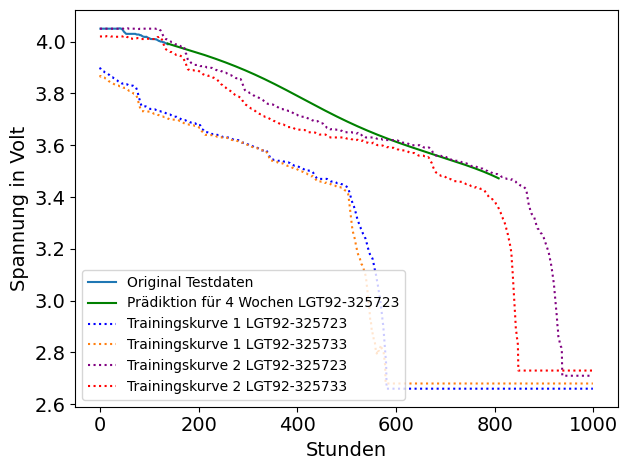

In [7]:
# generate prediction for testdata 23
where = -1
future_steps = 24 * 7 * 4
x_test = X_23_test[where]
current_input = x_test
print(f'Erster input: {current_input}')
y_test_future = np.zeros((future_steps,))
for i in range(future_steps):
    current_input = np.reshape(current_input, (1, window, indicators))
    y_test_future[i] = model.predict(current_input)
    print(f'Aktuelle Vorhersage{y_test_future[i]}')
    current_input = np.insert(current_input, window,
                              (y_test_future[i], x_test[0][1], x_test[0][2], x_test[0][3], x_test[0][4]), axis=1)
    print(current_input)
    current_input = np.delete(current_input, 0, axis=1)
    print(f'Input runde {i}: {current_input}')

to_descale = np.reshape(y_test_future, (-1, 1))
plt.plot(np.linspace(1, len(y_23_test_raw), len(y_23_test_raw)), y_23_test_raw, label='Original Testdaten')
plt.plot(np.arange(len(X_23_test) + window, len(X_23_test) + window + len(to_descale)),
         scaler_y.inverse_transform(to_descale), label='Prädiktion für 4 Wochen LGT92-325723', color='green')
df_325723_full_curve['rm_data_BatV'].plot(color='blue', linestyle='dotted', label='Trainingskurve 1 LGT92-325723')
df_325733_full_curve['rm_data_BatV'].plot(linestyle='dotted', label='Trainingskurve 1 LGT92-325733')
df_325723_full_curve_1['rm_data_BatV'].plot(color='purple', linestyle='dotted', label='Trainingskurve 2 LGT92-325723')
df_325733_full_curve_1['rm_data_BatV'].plot(color='red', linestyle='dotted', label='Trainingskurve 2 LGT92-325733')
plt.xlabel('Stunden', fontsize=fontsize)
plt.ylabel('Spannung in Volt', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.legend()
plt.tight_layout()
if save_plot:
    plt.savefig(f'../../data/png/evaluate_test_predict_future_Sensor23', pad_inches=2)
plt.show()


# Evaluation des Modells auf dem Testdatensatz des Sensor LGT92-325733
Evaluation und Visualisierung der Prädiktion über den gesamten Testdatensatz

4/4 [==============================] - 0s 34ms/step
Mean Absolute Error for multiple Forecast: 0.014499373956415904
Mean Squad Error for multiple Forecast: 9.610224957376891e-08


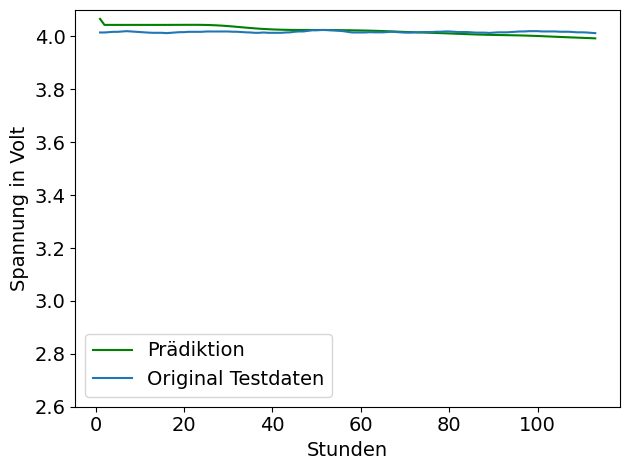

In [8]:
## Evaluation über X_33 TEST
# predict for testdata
y_pred_test_33 = model.predict(X_33_test)
# descale prediction
y_pred_test_inv_33 = scaler_y.inverse_transform(y_pred_test)

# Mean Absolute Error berechnen
mae_33 = mean_absolute_error(y_33_test_raw[:len(y_pred_test_inv_33)], y_pred_test_inv_33)
rmse_33 = np.square(mean_squared_error(y_33_test_raw[:len(y_pred_test_inv_33)], y_pred_test_inv_33))
# print mae & rmse
print("Mean Absolute Error for multiple Forecast:", mae_33)
print("Mean Squad Error for multiple Forecast:", rmse_33)

# plot results
plt.plot(np.linspace(1, len(y_pred_test_inv_33), len(y_pred_test_inv_33)), y_pred_test_inv_33, color='green',
         label='Prädiktion')
plt.plot(np.linspace(1, len(y_33_test_raw[:len(y_pred_test_inv_33)]), len(y_pred_test_inv_33)),
         y_33_test_raw[:len(y_pred_test_inv)],
         label='Original Testdaten')
plt.ylim(y_lim)
plt.xlabel('Stunden', fontsize=fontsize)
plt.ylabel('Spannung in Volt', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
if save_plot:
    plt.savefig(f'../../data/png/evaluate_test_predict_testdata_33', pad_inches=2)
plt.show()

## Evaluation des Modells auf dem Testdatensatz des Sensor LGT92-325733 für jeden Zeitschritt

1/1 [==============================] - 0s 16ms/step


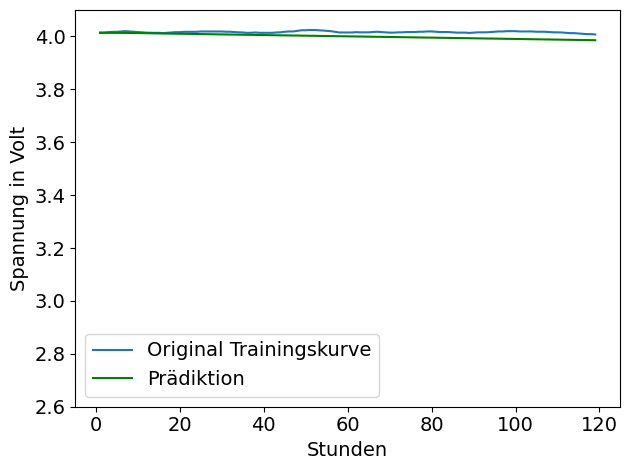

Mean Absolute Error for multiple Forecast: 0.016231054373570555
Root Mean Squad Error for multiple Forecast: 1.1114969685522294e-07


In [9]:
# multiple prediction over Testdata 325733
multi_pred_testdata_33 = ds.multiple_prediction(window_slot=1, window=window, indicators=indicators,
                                                future_steps=len(X_33_test), model=model, input_data=X_33_test,
                                                scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_33_test_raw, predicted=multi_pred_testdata_33, period=len(X_33_test), y_lim=y_lim,
                   window_slot=1, fontsize=14, data_name='multi_pred_testdata_33')

# Metriks
mae_mptd_33 = mean_absolute_error(y_33_test_raw[:len(multi_pred_testdata_33)], multi_pred_testdata_33)
rmse_mptd_33 = np.square(mean_squared_error(y_33_test_raw[:len(multi_pred_testdata_33)], multi_pred_testdata_33))
# print results of Metriks
print("Mean Absolute Error for multiple Forecast:", mae_mptd_33)
print("Root Mean Squad Error for multiple Forecast:", rmse_mptd_33)

## Visualisierung der Prädiktion des Modells auf dem Testdatensatz des Sensor LGT92-325733 über vier Wochen

Erster input: [[ 1.31410344 -1.          1.         -0.0316386  -0.59852677]
 [ 1.31469392 -1.          1.         -0.0316386  -0.59852677]
 [ 1.31469392 -1.          1.         -0.0316386  -0.59852677]
 [ 1.31233203 -1.          1.         -0.0316386  -0.59852677]
 [ 1.30997015 -1.          1.         -0.0316386  -0.59852677]
 [ 1.30760827 -1.          1.         -0.0316386  -0.59852677]
 [ 1.30524638 -1.          1.         -0.0316386  -0.59852677]
 [ 1.30524638 -1.          1.         -0.0316386  -0.59852677]
 [ 1.3028845  -1.          1.         -0.0316386  -0.59852677]
 [ 1.3028845  -1.          1.         -0.0316386  -0.59852677]
 [ 1.30052262 -1.          1.         -0.0316386  -0.59852677]
 [ 1.29816074 -1.          1.         -0.0316386  -0.59852677]
 [ 1.29816074 -1.          1.         -0.0316386  -0.59852677]
 [ 1.29816074 -1.          1.         -0.0316386  -0.59852677]
 [ 1.29579885 -1.          1.         -0.0316386  -0.59852677]
 [ 1.29579885 -1.          1.         -0.

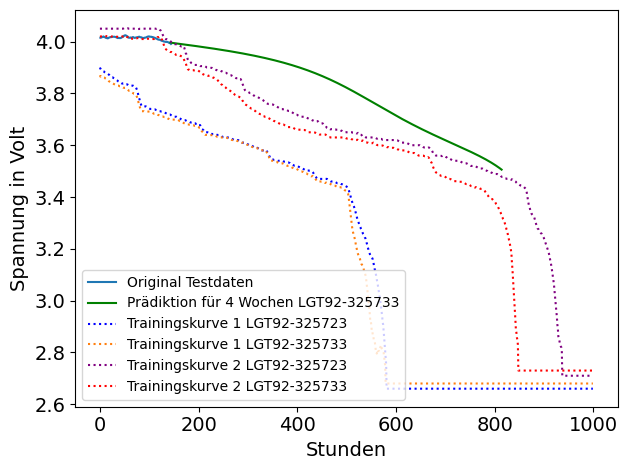

In [10]:
# Generiere Vorhersagen TESTDATEN 33
where = -1
future_steps = 24 * 7 * 4
x_test = X_33_test[where]
current_input = x_test
print(f'Erster input: {current_input}')
y_test_future = np.zeros((future_steps,))
for i in range(future_steps):
    current_input = np.reshape(current_input, (1, window, indicators))
    y_test_future[i] = model.predict(current_input)
    print(f'Aktuelle Vorhersage{y_test_future[i]}')
    current_input = np.insert(current_input, window,
                              (y_test_future[i], x_test[0][1], x_test[0][2], x_test[0][3], x_test[0][4]), axis=1)
    print(current_input)
    current_input = np.delete(current_input, 0, axis=1)
    print(f'Input runde {i}: {current_input}')

to_descale = np.reshape(y_test_future, (-1, 1))
plt.plot(np.linspace(1, len(y_33_test_raw), len(y_33_test_raw)), y_33_test_raw, label='Original Testdaten')
plt.plot(np.arange(len(X_33_test) + window, len(X_33_test) + window + len(to_descale)),
         scaler_y.inverse_transform(to_descale), label='Prädiktion für 4 Wochen LGT92-325733', color='green')
df_325723_full_curve['rm_data_BatV'].plot(color='blue', linestyle='dotted', label='Trainingskurve 1 LGT92-325723')
df_325733_full_curve['rm_data_BatV'].plot(linestyle='dotted', label='Trainingskurve 1 LGT92-325733')
df_325723_full_curve_1['rm_data_BatV'].plot(color='purple', linestyle='dotted', label='Trainingskurve 2 LGT92-325723')
df_325733_full_curve_1['rm_data_BatV'].plot(color='red', linestyle='dotted', label='Trainingskurve 2 LGT92-325733')
plt.xlabel('Stunden', fontsize=fontsize)
plt.ylabel('Spannung in Volt', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.legend()
plt.tight_layout()
if save_plot:
    plt.savefig(f'../../data/png/evaluate_test_predict_future_Sensor33', pad_inches=2)
plt.show()

## Evaluation des Modells auf dem Trainingsdatensatz (Prädiktion über eine Woche)

1/1 [==============================] - 0s 16ms/step


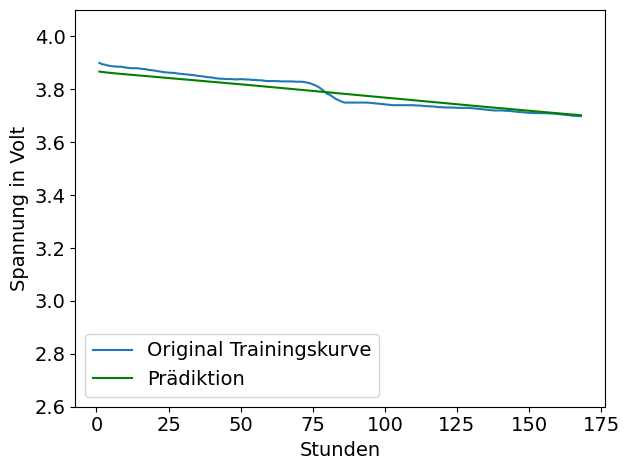

Mean Absolute Error for multiple Forecast: 0.018011874856497977
Root Mean Squad Error for multiple Forecast: 1.5285803665635612e-07


In [11]:
# multiple prediction for one week Trainingsdata
one_week = 24 * 7
one_week_pred = ds.multiple_prediction(window_slot=1, window=window, indicators=indicators, future_steps=one_week,
                                       model=model, input_data=X_train, scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_train_raw, predicted=one_week_pred, period=one_week, y_lim=y_lim, window_slot=1,
                   fontsize=fontsize, data_name='one_week')

# calculate Mean Absolute Error
mae_one_week_trainingsdata = mean_absolute_error(y_train_raw[:one_week], one_week_pred)
rmse_one_week_trainingsdata = np.square(mean_squared_error(y_train_raw[:one_week], one_week_pred))
# print results
print("Mean Absolute Error for multiple Forecast:", mae_one_week_trainingsdata)
print("Root Mean Squad Error for multiple Forecast:", rmse_one_week_trainingsdata)

## Evaluation des Modells auf dem Trainingsdatensatz (Prädiktion über zwei Wochen)

1/1 [==============================] - 0s 16ms/step


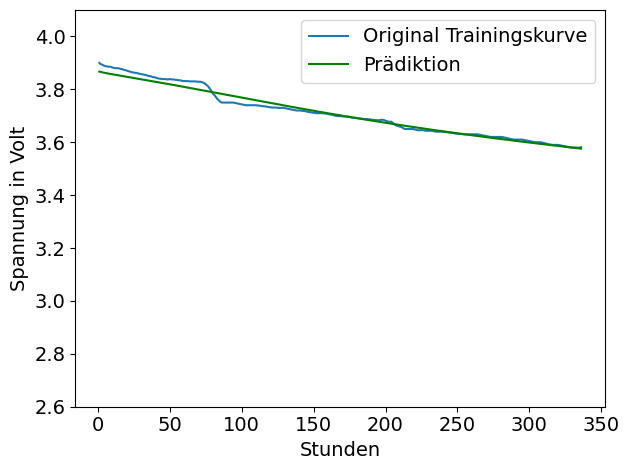

Mean Absolute Error for thee week Forecast on train Data: 0.011121790516981029
Root Mean Squad Error for multiple Forecast: 4.336648740833755e-08


In [12]:
# multiple prediction for two weeks trainingsdata
two_weeks = 24 * 7 * 2
two_weeks_pred = ds.multiple_prediction(window_slot=1, window=window, indicators=indicators, future_steps=two_weeks,
                                        model=model, input_data=X_train, scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_train_raw, predicted=two_weeks_pred, period=two_weeks, y_lim=y_lim, window_slot=1,
                   fontsize=fontsize, data_name='two_weeks')

# calculate Mean Absolute Error
mae_two_week_trainingsdata = mean_absolute_error(y_train_raw[:two_weeks], two_weeks_pred)
rmse_two_week_trainingsdata = np.square(mean_squared_error(y_train_raw[:two_weeks], two_weeks_pred))

# print results
print("Mean Absolute Error for thee week Forecast on train Data:", mae_two_week_trainingsdata)
print("Root Mean Squad Error for multiple Forecast:", rmse_two_week_trainingsdata)

## Evaluation des Modells auf dem Trainingsdatensatz (Prädiktion über drei Wochen)

1/1 [==============================] - 0s 18ms/step


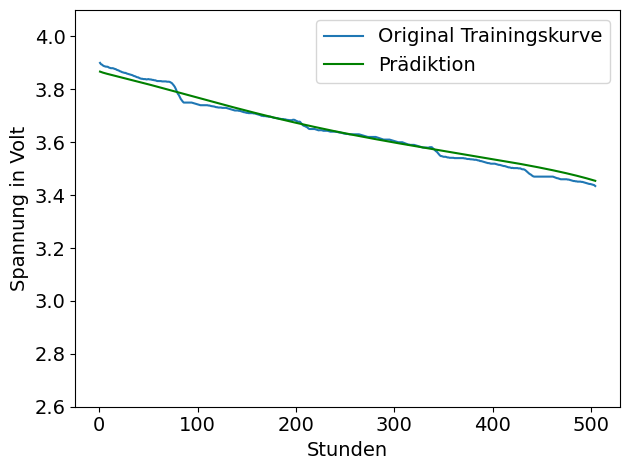

Mean Absolute Error for two week Forecast on train Data: 0.014239799166815373
Root Mean Squad Error for multiple Forecast: 8.586502722231636e-08


In [13]:
# multiple prediction for three weeks Trainingsdata
three_weeks = 24 * 7 * 3
three_weeks_pred = ds.multiple_prediction(window_slot=1, window=window, indicators=indicators, future_steps=three_weeks,
                                          model=model, input_data=X_train, scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_train_raw, predicted=three_weeks_pred, period=three_weeks, y_lim=y_lim, window_slot=1,
                   fontsize=fontsize, data_name='three_weeks')

# calculate Mean Absolute Error
mae_three_week_trainingsdata = mean_absolute_error(y_train_raw[:three_weeks], three_weeks_pred)
rmse_three_week_trainingsdata = np.square(mean_squared_error(y_train_raw[:three_weeks], three_weeks_pred))

# print results
print("Mean Absolute Error for two week Forecast on train Data:", mae_three_week_trainingsdata)
print("Root Mean Squad Error for multiple Forecast:", rmse_three_week_trainingsdata)

## Evaluation des Modells auf dem Trainingsdatensatz (Prädiktion über vier Wochen)

1/1 [==============================] - 0s 16ms/step


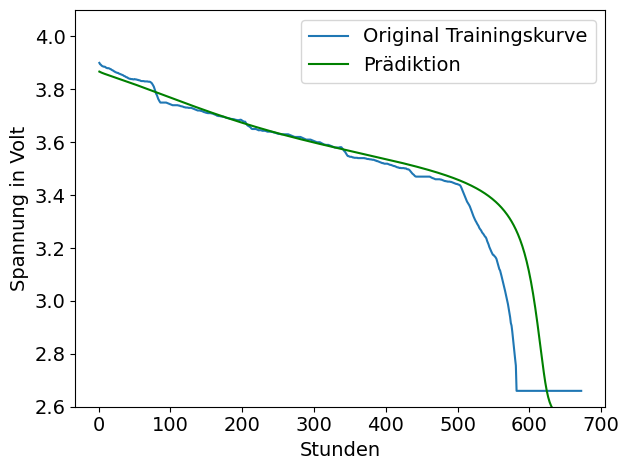

Mean Absolute Error for two week Forecast on train Data: 0.06306592860388315
Root Mean Squad Error for multiple Forecast: 0.00030854001395307047


In [14]:
# multiple prediction for four weeks Trainingsdata
four_weeks = 24 * 7 * 4
four_weeks_pred = ds.multiple_prediction(window_slot=1, window=window, indicators=indicators, future_steps=four_weeks,
                                         model=model, input_data=X_train, scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_train_raw, predicted=four_weeks_pred, period=four_weeks, y_lim=y_lim, window_slot=1,
                   fontsize=fontsize, data_name='four_weeks')

# calculate Mean Absolute Error
mae_four_week_trainingsdata = mean_absolute_error(y_train_raw[:four_weeks], four_weeks_pred)
rmse_four_week_trainingsdata = np.square(mean_squared_error(y_train_raw[:four_weeks], four_weeks_pred))

# print results
print("Mean Absolute Error for two week Forecast on train Data:", mae_four_week_trainingsdata)
print("Root Mean Squad Error for multiple Forecast:", rmse_four_week_trainingsdata)

# Evaluation des Modells auf den Spannungsverlaufsdaten des Sensor LGT92-325744 (Prädiktion über eine Woche, erste Spannungsverlaufskurve)

1/1 [==============================] - 0s 17ms/step


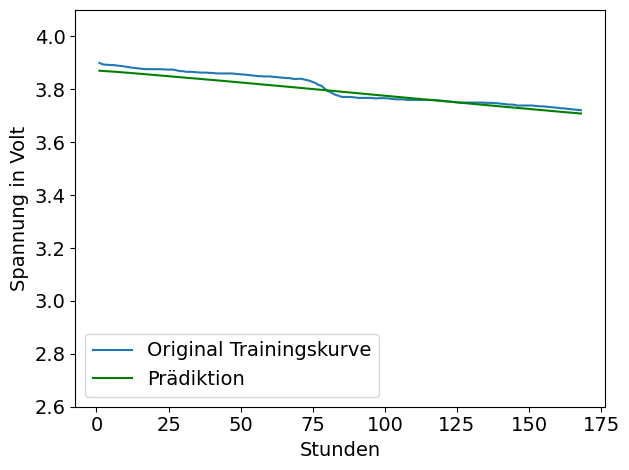

Mean Absolute Error for multiple Forecast: 0.01738954153338753
Root Mean Squad Error for multiple Forecast: 1.592045674245125e-07


In [15]:
# multiple prediction for one week LG92-44
one_week = 24 * 7
one_week_pred_44 = ds.multiple_prediction(window_slot=1, window=window, indicators=indicators, future_steps=one_week,
                                          model=model, input_data=X_44_test, scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_test_44_raw, predicted=one_week_pred_44, period=one_week, y_lim=y_lim, window_slot=1,
                   fontsize=fontsize, data_name='one_week_Sensor_44')

# calculate Mean Absolute Error
mae_one_week_trainingsdata_44 = mean_absolute_error(y_test_44_raw[:one_week], one_week_pred_44)
rmse_one_week_trainingsdata_44 = np.square(mean_squared_error(y_test_44_raw[:one_week], one_week_pred_44))
# print results
print("Mean Absolute Error for multiple Forecast:", mae_one_week_trainingsdata_44)
print("Root Mean Squad Error for multiple Forecast:", rmse_one_week_trainingsdata_44)


# Evaluation des Modells auf den Spannungsverlaufsdaten des Sensor LGT92-325744 (Prädiktion über zwei Wochen, erste Spannungsverlaufskurve)

1/1 [==============================] - 0s 17ms/step


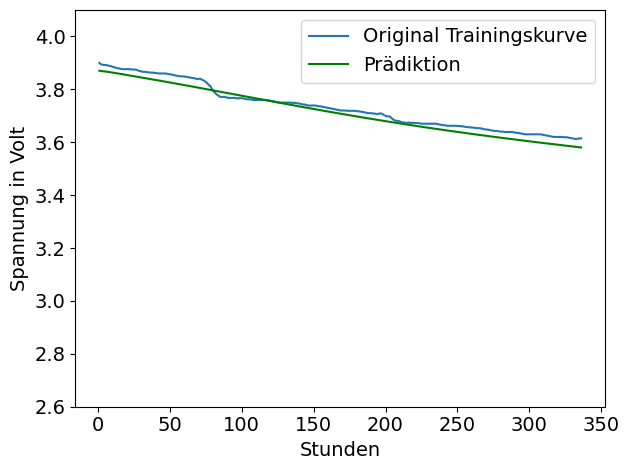

Mean Absolute Error for multiple Forecast: 0.019592699597335977
Root Mean Squad Error for multiple Forecast: 2.1173152307265766e-07


In [16]:
# multiple prediction for two weeks LG92-44
two_weeks = 24 * 7 * 2
two_weeks_pred_44 = ds.multiple_prediction(window_slot=1, window=window, indicators=indicators, future_steps=two_weeks,
                                           model=model, input_data=X_44_test, scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_test_44_raw, predicted=two_weeks_pred_44, period=two_weeks, y_lim=y_lim, window_slot=1,
                   fontsize=fontsize, data_name='two_weeks_Sensor_44')

# calculate Mean Absolute Error
mae_two_week_trainingsdata_44 = mean_absolute_error(y_test_44_raw[:two_weeks], two_weeks_pred_44)
rmse_two_week_trainingsdata_44 = np.square(mean_squared_error(y_test_44_raw[:two_weeks], two_weeks_pred_44))
# print results
print("Mean Absolute Error for multiple Forecast:", mae_two_week_trainingsdata_44)
print("Root Mean Squad Error for multiple Forecast:", rmse_two_week_trainingsdata_44)

# Evaluation des Modells auf den Spannungsverlaufsdaten des Sensor LGT92-325744 (Prädiktion über drei Wochen, erste Spannungsverlaufskurve)

1/1 [==============================] - 0s 16ms/step


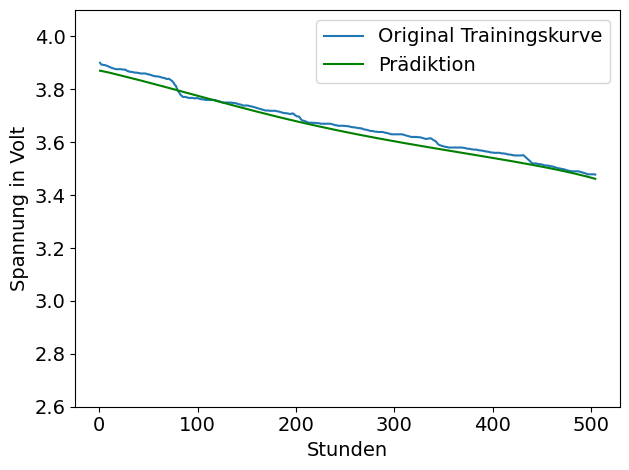

Mean Absolute Error for multiple Forecast: 0.018379992605839775
Root Mean Squad Error for multiple Forecast: 1.671041439066649e-07


In [17]:
# multiple prediction for three weeks LG92-44
three_weeks = 24 * 7 * 3
three_weeks_pred_44 = ds.multiple_prediction(window_slot=1, window=window, indicators=indicators,
                                             future_steps=three_weeks,
                                             model=model, input_data=X_44_test, scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_test_44_raw, predicted=three_weeks_pred_44, period=three_weeks, y_lim=y_lim, window_slot=1,
                   fontsize=fontsize, data_name='three_weeks_Sensor_44')

# calculate Mean Absolute Error
mae_three_week_testdata_44 = mean_absolute_error(y_test_44_raw[:three_weeks], three_weeks_pred_44)
rmse_three_week_testdata_44 = np.square(mean_squared_error(y_test_44_raw[:three_weeks], three_weeks_pred_44))
# print results
print("Mean Absolute Error for multiple Forecast:", mae_three_week_testdata_44)
print("Root Mean Squad Error for multiple Forecast:", rmse_three_week_testdata_44)

# Evaluation des Modells auf den Spannungsverlaufsdaten des Sensor LGT92-325744 (Prädiktion über vier Wochen, erste Spannungsverlaufskurve)

1/1 [==============================] - 0s 17ms/step


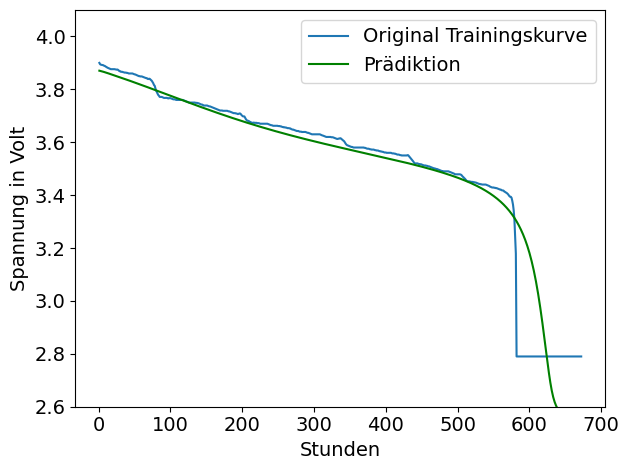

Mean Absolute Error for multiple Forecast: 0.05152760002113087
Root Mean Squad Error for multiple Forecast: 0.000131064059176395


In [18]:
# multiple prediction for four weeks LG92-44
four_weeks = 24 * 7 * 4
four_weeks_pred_44 = ds.multiple_prediction(window_slot=1, window=window, indicators=indicators,
                                            future_steps=four_weeks,
                                            model=model, input_data=X_44_test, scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_test_44_raw, predicted=four_weeks_pred_44, period=four_weeks, y_lim=y_lim,
                   window_slot=1,
                   fontsize=fontsize, data_name='four_weeks_Sensor_44')

# calculate Mean Absolute Error
mae_four_week_testdata_44 = mean_absolute_error(y_test_44_raw[:four_weeks], four_weeks_pred_44)
rmse_four_week_testdata_44 = np.square(mean_squared_error(y_test_44_raw[:four_weeks], four_weeks_pred_44))
# print results
print("Mean Absolute Error for multiple Forecast:", mae_four_week_testdata_44)
print("Root Mean Squad Error for multiple Forecast:", rmse_four_week_testdata_44)

# Evaluation des Modells auf den Spannungsverlaufsdaten des Sensor LGT92-325744 (Prädiktion über vier Wochen, zweite Spannungsverlaufskurve)

1/1 [==============================] - 0s 17ms/step


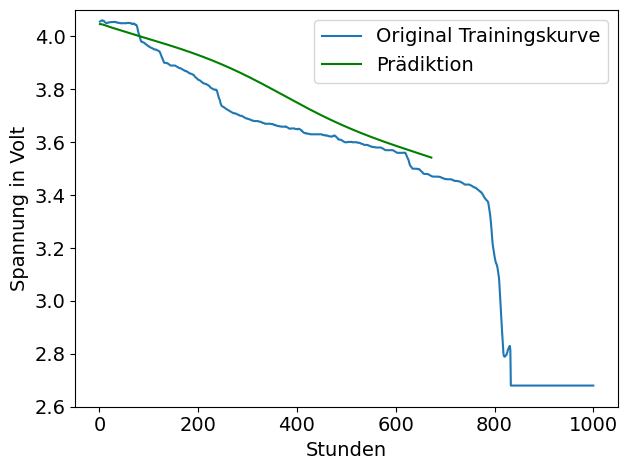

Mean Absolute Error for multiple Forecast: 0.07511084022938107
Root Mean Squad Error for multiple Forecast: 5.980999714743509e-05


In [19]:
# multiple prediction for weeks
four_weeks = 24 * 7 * 4
four_weeks_pred_44_curve_2 = ds.multiple_prediction(window_slot=1001, window=window, indicators=indicators,
                                            future_steps=four_weeks,
                                            model=model, input_data=X_44_test, scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_test_44_raw, predicted=four_weeks_pred_44_curve_2, period=1000, y_lim=y_lim,
                   window_slot=1, offset=1000,
                   fontsize=fontsize, data_name='four_weeks_Sensor_44')

# calculate Mean Absolute Error
mae_four_week_testdata_44_curve_2 = mean_absolute_error(y_test_44_raw[1000:1000 + four_weeks], four_weeks_pred_44_curve_2)
rmse_four_week_testdata_44_curve_2 = np.square(mean_squared_error(y_test_44_raw[1000: 1000 + four_weeks], four_weeks_pred_44_curve_2))
# print results
print("Mean Absolute Error for multiple Forecast:", mae_four_week_testdata_44_curve_2)
print("Root Mean Squad Error for multiple Forecast:", rmse_four_week_testdata_44_curve_2)